In [66]:
import cv2
import numpy as np
import os 
from random import shuffle
from tqdm import tqdm
import glob
import pandas as pd
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, Activation, Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy
from scipy import ndimage
try:
    import scipy
    print(scipy.__version__)
    print(ndimage.affine_transform.__doc__)
    from scipy import ndimage 
except ImportError as e:
    print ('test .....', e)
    scipy = None



1.8.0

    Apply an affine transformation.

    Given an output image pixel index vector ``o``, the pixel value
    is determined from the input image at position
    ``np.dot(matrix, o) + offset``.

    This does 'pull' (or 'backward') resampling, transforming the output space
    to the input to locate data. Affine transformations are often described in
    the 'push' (or 'forward') direction, transforming input to output. If you
    have a matrix for the 'push' transformation, use its inverse
    (:func:`numpy.linalg.inv`) in this function.

    Parameters
    ----------
    input : array_like
        The input array.
    matrix : ndarray
        The inverse coordinate transformation matrix, mapping output
        coordinates to input coordinates. If ``ndim`` is the number of
        dimensions of ``input``, the given matrix must have one of the
        following shapes:

            - ``(ndim, ndim)``: the linear transformation matrix for each
              output coordinate.
     

In [67]:
TRAIN_DIR = r'./train/'
print(TRAIN_DIR)
TEST_DIR = r'./test/'
print(TRAIN_DIR)
IMG_SIZE = 100
LR = 1e-3 

MODEL_NAME = 'dogvscats--{}--{}.model'.format(LR,'conv-basic')

val_loss = {}
accuracy = {}


./train/
./train/


In [68]:
os.listdir(TRAIN_DIR)

['dog.8011.jpg',
 'cat.5077.jpg',
 'dog.7322.jpg',
 'cat.2718.jpg',
 'cat.10151.jpg',
 'cat.3406.jpg',
 'dog.1753.jpg',
 'cat.4369.jpg',
 'cat.7660.jpg',
 'dog.5535.jpg',
 'cat.8553.jpg',
 'cat.9895.jpg',
 'cat.1211.jpg',
 'dog.3144.jpg',
 'dog.775.jpg',
 'dog.11102.jpg',
 'cat.6218.jpg',
 'dog.11664.jpg',
 'dog.3622.jpg',
 'cat.1577.jpg',
 'cat.12020.jpg',
 'dog.5253.jpg',
 'cat.7106.jpg',
 'cat.8235.jpg',
 'cat.952.jpg',
 'dog.9469.jpg',
 'dog.1035.jpg',
 'cat.3360.jpg',
 'cat.11529.jpg',
 'cat.10637.jpg',
 'dog.6982.jpg',
 'dog.8777.jpg',
 'dog.7444.jpg',
 'cat.5711.jpg',
 'cat.946.jpg',
 'cat.3374.jpg',
 'dog.1021.jpg',
 'dog.6996.jpg',
 'cat.10623.jpg',
 'dog.8763.jpg',
 'cat.5705.jpg',
 'dog.7450.jpg',
 'dog.12379.jpg',
 'dog.11670.jpg',
 'dog.4159.jpg',
 'cat.1563.jpg',
 'dog.3636.jpg',
 'cat.12034.jpg',
 'dog.2528.jpg',
 'cat.7112.jpg',
 'dog.5247.jpg',
 'cat.8221.jpg',
 'dog.10208.jpg',
 'dog.5521.jpg',
 'cat.7674.jpg',
 'cat.8547.jpg',
 'cat.9881.jpg',
 'dog.761.jpg',
 'dog.3

In [69]:
class_name = [i.split('.')[0] for i in os.listdir(TRAIN_DIR)]
image_name =  [i for i in os.listdir(TRAIN_DIR)]

In [70]:
df = pd.DataFrame({'class_name':class_name,'image_name':image_name} )

In [71]:
df.drop(df.index[-1], inplace=True)

In [72]:
df

,class_name,image_name
0,dog,dog.8011.jpg
1,cat,cat.5077.jpg
2,dog,dog.7322.jpg
3,cat,cat.2718.jpg
4,cat,cat.10151.jpg
...,...,...
24994,dog,dog.6025.jpg
24995,dog,dog.8008.jpg
24996,dog,dog.1992.jpg
24997,dog,dog.12412.jpg


In [73]:
train_datagen = ImageDataGenerator(
                rotation_range=15, 
                rescale=1./255,
                shear_range=0.1, 
                zoom_range=0.2,
                horizontal_flip=True, 
                width_shift_range=0.1,
                height_shift_range=0.1,
                validation_split=0.2)

In [74]:
train_generator = train_datagen.flow_from_dataframe(
                    df,
                    TRAIN_DIR, 
                    x_col = 'image_name',
                    y_col = 'class_name',
                    target_size =(224,224),
                    class_mode = 'binary',
                    batch_size=32,
                    shuffle=False,
                    subset= 'training')

val_generator = train_datagen.flow_from_dataframe(
                    df,
                    TRAIN_DIR, 
                    x_col = 'image_name',
                    y_col = 'class_name',
                    target_size =(224,224),
                    class_mode = 'binary',
                    batch_size=32,
                    shuffle=False,
                    subset= 'validation')



Found 20000 validated image filenames belonging to 2 classes.
Found 4999 validated image filenames belonging to 2 classes.


In [75]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                validation_split=0.2)


train_generator = train_datagen.flow_from_dataframe(
                    df,
                    TRAIN_DIR, 
                    x_col = 'image_name',
                    y_col = 'class_name',
                    target_size =(224,224),
                    class_mode = 'binary',
                    batch_size=32,
                    shuffle=False,
                    subset= 'training')

val_generator = train_datagen.flow_from_dataframe(
                    df,
                    TRAIN_DIR, 
                    x_col = 'image_name',
                    y_col = 'class_name',
                    target_size =(224,224),
                    class_mode = 'binary',
                    batch_size=32,
                    shuffle=False,
                    subset= 'validation')

Found 20000 validated image filenames belonging to 2 classes.
Found 4999 validated image filenames belonging to 2 classes.


In [76]:
input = Input(shape=(224,224, 3))

x = Conv2D(filters=256,kernel_size=3,padding='same' )(input)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x = MaxPool2D(pool_size=2)(x)


x = Conv2D(filters=128,kernel_size=3,padding='same' )(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x = MaxPool2D(pool_size=2)(x)


x = Conv2D(filters=64,kernel_size=3,padding='same' )(x)
x = BatchNormalization()(x)
x = Activation('tanh')(x)
x = MaxPool2D(pool_size=2)(x)


x = Flatten()(x)
output= Dense(1, activation='sigmoid')(x)


In [77]:
model = Model(input, output)

In [78]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 224, 224, 256)     7168      
_________________________________________________________________
batch_normalization_9 (Batch (None, 224, 224, 256)     1024      
_________________________________________________________________
activation_9 (Activation)    (None, 224, 224, 256)     0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 256)     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 128)     295040    
_________________________________________________________________
batch_normalization_10 (Batc (None, 112, 112, 128)     512 

In [79]:
model.compile(loss='binary_crossentropy', metrics='accuracy', optimizer='adam')

In [80]:
model.fit(train_generator  , validation_data=val_generator, steps_per_epoch = 128,  epochs=50)

Epoch 1/50


2022-10-24 18:28:12.854685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - ETA: 0s - loss: 1.4688 - accuracy: 0.5735

2022-10-24 18:30:06.443077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 133s 1s/step - loss: 1.4688 - accuracy: 0.5735 - val_loss: 1.0440 - val_accuracy: 0.5365
Epoch 2/50
128/128 [==============================] - 136s 1s/step - loss: 1.2727 - accuracy: 0.6006 - val_loss: 1.1831 - val_accuracy: 0.5399
Epoch 3/50
128/128 [==============================] - 138s 1s/step - loss: 1.3195 - accuracy: 0.6147 - val_loss: 1.1388 - val_accuracy: 0.5913
Epoch 4/50
128/128 [==============================] - 137s 1s/step - loss: 1.1513 - accuracy: 0.6289 - val_loss: 1.8769 - val_accuracy: 0.5669
Epoch 5/50
128/128 [==============================] - 134s 1s/step - loss: 1.1908 - accuracy: 0.6331 - val_loss: 1.2402 - val_accuracy: 0.6005
Epoch 6/50
128/128 [==============================] - 135s 1s/step - loss: 1.0391 - accuracy: 0.6587 - val_loss: 0.9629 - val_accuracy: 0.6259
Epoch 7/50
128/128 [==============================] - 135s 1s/step - loss: 1.0217 - accuracy: 0.6567 - val_loss: 1.1906 - val_accuracy: 0.6059
Epoch 8/50

In [81]:
model.history.history

{'loss': [1.4687620401382446,
  1.2727460861206055,
  1.3195074796676636,
  1.1512901782989502,
  1.1907505989074707,
  1.0390645265579224,
  1.0216974020004272,
  0.8917837142944336,
  0.891350507736206,
  0.9833939075469971,
  0.778853178024292,
  0.7520870566368103,
  0.7365245223045349,
  0.7167022824287415,
  0.6725408434867859,
  0.6113286018371582,
  0.5809465050697327,
  0.5774073004722595,
  0.5644024014472961,
  0.5492350459098816,
  0.5382190346717834,
  0.5194021463394165,
  0.5591006875038147,
  0.514444887638092,
  0.49079015851020813,
  0.5014520287513733,
  0.46905797719955444,
  0.4496241807937622,
  0.4366001784801483,
  0.41430142521858215,
  0.41060641407966614,
  0.4132852554321289,
  0.4046526849269867,
  0.39299508929252625,
  0.3719739317893982,
  0.4182925820350647,
  0.38779914379119873,
  0.37863895297050476,
  0.3738428056240082,
  0.337129682302475,
  0.360059529542923,
  0.37565910816192627,
  0.3526608645915985,
  0.36164209246635437,
  0.3323668539524078

In [82]:
val_loss['conv_256_128_64'] = model.history.history['val_loss']
accuracy['conv_256_128_64'] = model.history.history['accuracy']

<AxesSubplot:>

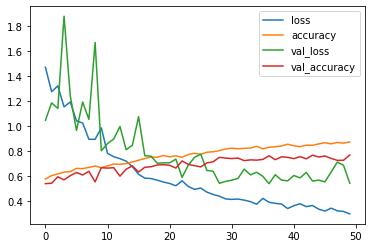

In [83]:
pd.DataFrame(model.history.history).plot()

In [84]:
input = Input(shape=(224,224, 3))

x = Conv2D(filters=256,kernel_size=3,padding='same' )(input)
x = Conv2D(filters=256,kernel_size=3,padding='same' )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=2)(x)


x = Conv2D(filters=128,kernel_size=3,padding='same' )(x)
x = Conv2D(filters=128,kernel_size=3,padding='same' )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=2)(x)


x = Conv2D(filters=64,kernel_size=3,padding='same' )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D(pool_size=2)(x)


x = Flatten()(x)
output= Dense(1, activation='sigmoid')(x)
model

In [85]:
model.compile(loss='binary_crossentropy', metrics='accuracy', optimizer='sgd')

In [86]:
model.fit(train_generator, validation_data=val_generator, steps_per_epoch = 128,  epochs=50)

Epoch 1/50


2022-10-24 20:22:19.428574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - ETA: 0s - loss: 0.2499 - accuracy: 0.8933

2022-10-24 20:24:15.313616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 135s 1s/step - loss: 0.2499 - accuracy: 0.8933 - val_loss: 0.4975 - val_accuracy: 0.7844
Epoch 2/50
128/128 [==============================] - 132s 1s/step - loss: 0.2369 - accuracy: 0.9116 - val_loss: 0.4995 - val_accuracy: 0.7896
Epoch 3/50
128/128 [==============================] - 136s 1s/step - loss: 0.2364 - accuracy: 0.9070 - val_loss: 0.5039 - val_accuracy: 0.7864
Epoch 4/50
128/128 [==============================] - 139s 1s/step - loss: 0.2193 - accuracy: 0.9160 - val_loss: 0.5009 - val_accuracy: 0.7846
Epoch 5/50
128/128 [==============================] - 140s 1s/step - loss: 0.2187 - accuracy: 0.9124 - val_loss: 0.5076 - val_accuracy: 0.7864
Epoch 6/50
128/128 [==============================] - 143s 1s/step - loss: 0.2119 - accuracy: 0.9182 - val_loss: 0.5076 - val_accuracy: 0.7902
Epoch 7/50
128/128 [==============================] - 137s 1s/step - loss: 0.2237 - accuracy: 0.9109 - val_loss: 0.5167 - val_accuracy: 0.7884
Epoch 8/50

In [87]:
val_loss['conv_256x2_128x2_64'] = model.history.history['val_loss']
accuracy['conv_256x2_128x2_64'] = model.history.history['accuracy']

<AxesSubplot:>

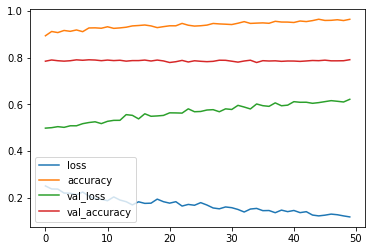

In [88]:
pd.DataFrame(model.history.history).plot()

In [89]:
input = Input(shape=(224,224, 3))

x = Conv2D(filters=128,kernel_size=3, strides=2 )(input)
x = Conv2D(filters=128,kernel_size=3, strides=2 )(x)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = MaxPool2D(pool_size=2)(x)


x = Conv2D(filters=64,kernel_size=3, strides=2 )(x)
x = Conv2D(filters=64,kernel_size=3, strides=2 )(x)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.8)(x)



x = Flatten()(x)
output= Dense(1, activation='sigmoid')(x)
model = Model(input, output)

In [90]:
model.compile(loss='binary_crossentropy', metrics='accuracy', optimizer='adam')
model.fit(train_generator, validation_data=val_generator, steps_per_epoch = 128,  epochs=50)

Epoch 1/50


2022-10-24 22:15:21.116120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - ETA: 0s - loss: 1.0783 - accuracy: 0.5352

2022-10-24 22:15:38.104618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 24s 176ms/step - loss: 1.0783 - accuracy: 0.5352 - val_loss: 0.9574 - val_accuracy: 0.4959
Epoch 2/50
128/128 [==============================] - 22s 174ms/step - loss: 0.7936 - accuracy: 0.5830 - val_loss: 0.6675 - val_accuracy: 0.6039
Epoch 3/50
128/128 [==============================] - 22s 174ms/step - loss: 0.6977 - accuracy: 0.6179 - val_loss: 0.7856 - val_accuracy: 0.5313
Epoch 4/50
128/128 [==============================] - 22s 175ms/step - loss: 0.6598 - accuracy: 0.6418 - val_loss: 0.6236 - val_accuracy: 0.6395
Epoch 5/50
128/128 [==============================] - 22s 175ms/step - loss: 0.6439 - accuracy: 0.6572 - val_loss: 0.6129 - val_accuracy: 0.6629
Epoch 6/50
128/128 [==============================] - 22s 175ms/step - loss: 0.6298 - accuracy: 0.6633 - val_loss: 0.6693 - val_accuracy: 0.6265
Epoch 7/50
128/128 [==============================] - 23s 176ms/step - loss: 0.6066 - accuracy: 0.6799 - val_loss: 0.6007 - val_accuracy: 0.6

In [91]:
val_loss['conv_128x2_64x2'] = model.history.history['val_loss']
accuracy['conv_128x2_64x2'] = model.history.history['accuracy']

<AxesSubplot:>

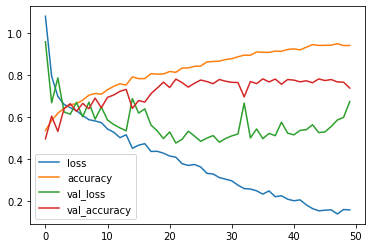

In [92]:
pd.DataFrame(model.history.history).plot()

In [94]:
input = Input(shape=(224,224, 3))


x = Conv2D(filters=64,kernel_size=3, strides=2 )(input)
x = Conv2D(filters=64,kernel_size=3, strides=2 )(x)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.8)(x)

x = Conv2D(filters=32,kernel_size=3, strides=2 )(x)
x = Conv2D(filters=32,kernel_size=3, strides=2 )(x)
x = BatchNormalization()(x)
x = Activation('selu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.8)(x)



x = Flatten()(x)
output= Dense(1, activation='sigmoid')(x)
model = Model(input, output)


model.compile(loss='binary_crossentropy', metrics='accuracy', optimizer='adam')
model.fit(train_generator, validation_data=val_generator, steps_per_epoch = 128,  epochs=50)

Epoch 1/50


2022-10-24 22:46:56.174187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - ETA: 0s - loss: 1.1210 - accuracy: 0.5232

2022-10-24 22:47:05.448916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 18s 132ms/step - loss: 1.1210 - accuracy: 0.5232 - val_loss: 0.6855 - val_accuracy: 0.5497
Epoch 2/50
128/128 [==============================] - 16s 129ms/step - loss: 0.8570 - accuracy: 0.5730 - val_loss: 0.6854 - val_accuracy: 0.5593
Epoch 3/50
128/128 [==============================] - 16s 125ms/step - loss: 0.7283 - accuracy: 0.6162 - val_loss: 0.6802 - val_accuracy: 0.5769
Epoch 4/50
128/128 [==============================] - 16s 125ms/step - loss: 0.6955 - accuracy: 0.6267 - val_loss: 0.6800 - val_accuracy: 0.5819
Epoch 5/50
128/128 [==============================] - 15s 121ms/step - loss: 0.6430 - accuracy: 0.6606 - val_loss: 0.6646 - val_accuracy: 0.5969
Epoch 6/50
128/128 [==============================] - 15s 121ms/step - loss: 0.6226 - accuracy: 0.6628 - val_loss: 0.6731 - val_accuracy: 0.5809
Epoch 7/50
128/128 [==============================] - 15s 120ms/step - loss: 0.5889 - accuracy: 0.6921 - val_loss: 0.6448 - val_accuracy: 0.6

In [ ]:
val_loss['conv_128x2_64x2_32x2'] = model.history.history['val_loss']
accuracy['conv_128x2_64x2_32x2'] = model.history.history['accuracy']

In [ ]:
pd.DataFrame(model.history.history).plot()

<AxesSubplot:>

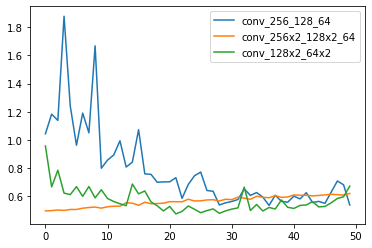

In [97]:

pd.DataFrame(val_loss).plot()

<AxesSubplot:>

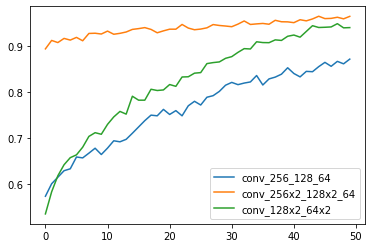

In [98]:

pd.DataFrame(accuracy).plot()

In [ ]:
y_pred = model.predict(val_generator)

In [ ]:
y_pred  = y_pred>0.5

In [ ]:
y_test = val_generator.classes

In [ ]:
y_pred 

<tf.Tensor: shape=(4999,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

Text(0.5, 1.0, 'Confusion Matrix')

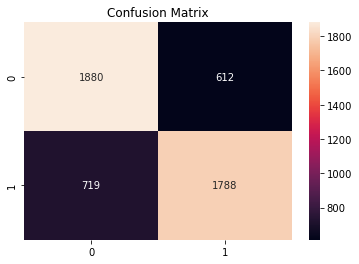

In [ ]:
import seaborn as sns
sns.heatmap(tf.math.confusion_matrix(y_test, y_pred), annot=True, fmt='g')
plt.title('Confusion Matrix')